In [10]:
import cv2
import streamlink
import subprocess
import datetime
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

In [23]:
def capture_screenshot(stream_url: str, identifier: str) -> np.array:
    streams = streamlink.streams(stream_url)
    #print(streams)
    url = streams['best'].url
    #print(url)
    cap = cv2.VideoCapture(url)
    success, img_bgr = cap.read()
    filename = '{}-{}.jpg'.format(identifier, datetime.datetime.now())
    cv2.imwrite(filename, img_bgr)
    return img_bgr

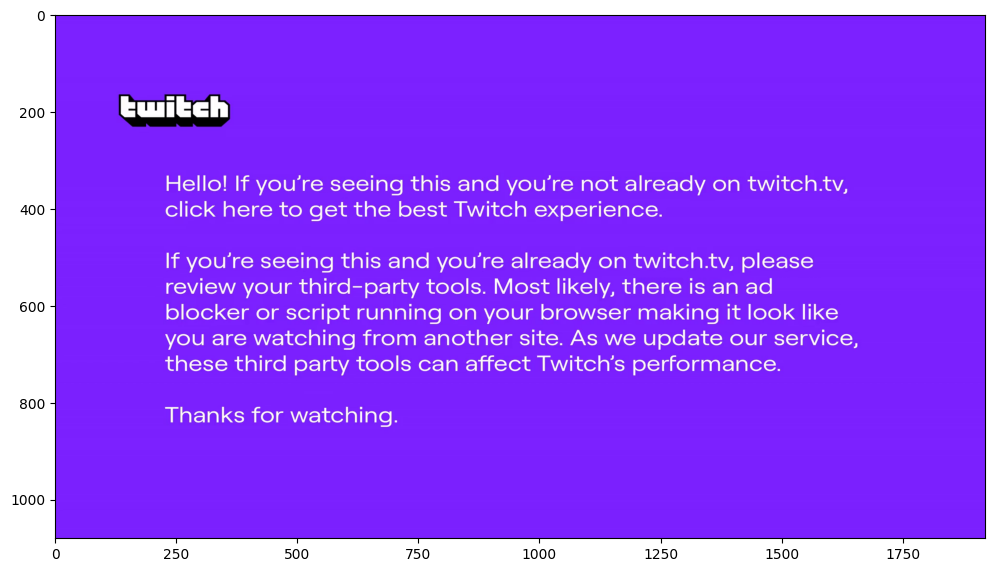

In [24]:
STREAM = 'http://twitch.tv/tsm_imperialhal'
img_bgr = capture_screenshot(STREAM, 'tsm_imperialhal')
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)

In [173]:
from subprocess import Popen, PIPE, STDOUT
import os
import threading
import time

def log_subprocess_output(pipe):
    for line in iter(pipe.readline, b''): # b'\n'-separated lines
        print(line)
    pipe.close()
    
def get_file_size(path):
    if not os.path.exists(path):
        return None
    size_bytes = os.stat(path).st_size
    return size_bytes/(1024**2)
        
def kill_process_when_size_reached(process, path, size_mb):
    while True:
        file_size = get_file_size(path)
        if file_size is not None and file_size >= size_mb:
            process.kill()
            break
        time.sleep(0.1)

MAX_SIZE = 3
def get_twitch_screenshot(token: str, user: str) -> np.array:
    timestamp = datetime.datetime.now().strftime("%Y_%m_%d-%I_%M_%S_%p")
    
    # First, download some raw video from the stream
    filename_orig = '{}-{}.rawvideo'.format(user, timestamp)
    command = [
        'streamlink', 
        '--twitch-disable-reruns', 
        '--twitch-disable-ads',
        '--twitch-disable-hosting',
        '--twitch-low-latency',
        'https://twitch.tv/{}'.format(user),
        'best',
        '-o',
        filename_orig
    ]
    #print(' '.join(command))
    process = Popen(command, stdout=PIPE, stderr=STDOUT)
    process_watcher = threading.Thread(target=kill_process_when_size_reached, args=(process, filename_orig, MAX_SIZE))
    process_watcher.start()
    exitcode = process.wait() # 0 means success
    process_watcher.join()
    
    # Next, extract a frame using ffmpeg
    output_image_path = '{}-{}.jpg'.format(user, timestamp)
    command = [
        'ffmpeg',
        '-ss',
        '00:00:00',
        '-i', filename_orig,
        '-vframes', '1', '-q:v', '1',
        output_image_path
    ]
    process = Popen(command, stdout=PIPE, stderr=STDOUT)
    exitcode = process.wait() # 0 means success
    
    # Remove the original video file
    os.remove(filename_orig)
    
    return output_image_path

OAUTH_TOKEN = "5w18kn21v8saevz2egvcspvy2pqjvt"
USER = "tsm_imperialhal"#"nokokopuffs"#

path = get_twitch_screenshot(OAUTH_TOKEN, USER)

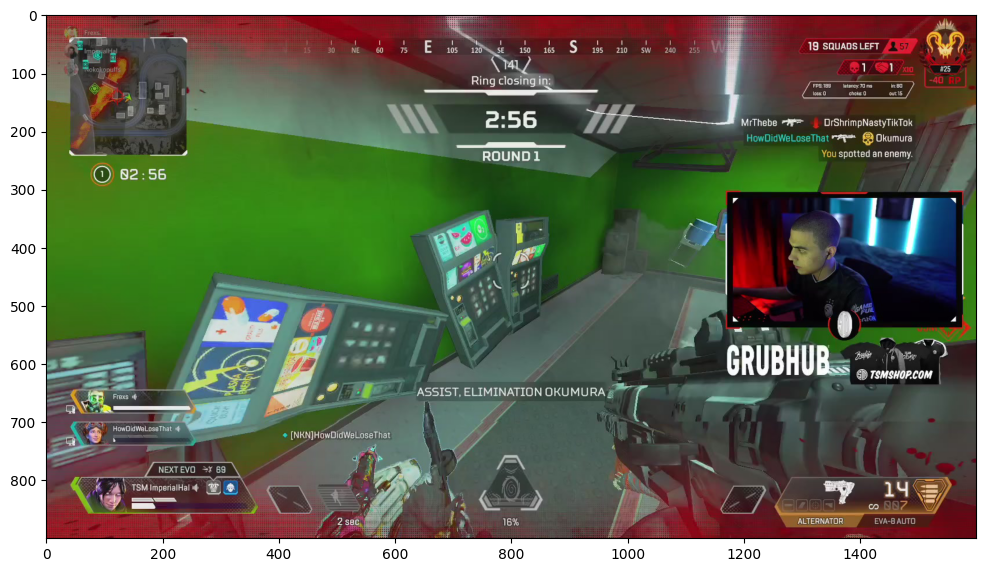

In [174]:
img = plt.imread(path)
plt.imshow(img)

[cli][info] streamlink is running as root! Be careful!
[cli][info] Found matching plugin twitch for URL https://twitch.tv/nokopuffs
error: No playable streams found on this URL: https://twitch.tv/nokopuffs


In [192]:
# Image Matching Experiment
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt

img = cv.imread("tsm_imperialhal-2021_01_22-01_31_56_AM.jpg",0)
template = cv.imread('assists_icon.jpg',0)

def find_template_in_image(image, template):
    w, h = template.shape[::-1]
    res = cv.matchTemplate(image, template, cv.TM_CCOEFF_NORMED)
    min_val, max_val, min_loc, max_loc = cv.minMaxLoc(res)
    top_left = max_loc
    bottom_right = (top_left[0] + w + 15, top_left[1] + h + 15)
    return (top_left, bottom_right)

find_template_in_image(img, template)

((1422, 83), (1460, 116))

In [193]:
import pickle
pickle.dumps(template)

b'\x80\x04\x95+\x02\x00\x00\x00\x00\x00\x00\x8c\x15numpy.core.multiarray\x94\x8c\x0c_reconstruct\x94\x93\x94\x8c\x05numpy\x94\x8c\x07ndarray\x94\x93\x94K\x00\x85\x94C\x01b\x94\x87\x94R\x94(K\x01K\x12K\x17\x86\x94h\x03\x8c\x05dtype\x94\x93\x94\x8c\x02u1\x94\x89\x88\x87\x94R\x94(K\x03\x8c\x01|\x94NNNJ\xff\xff\xff\xffJ\xff\xff\xff\xffK\x00t\x94b\x89B\x9e\x01\x00\x00%9Ki~\xa9\xbf\xdc\xe1\xe4o\x92\xe6\xd6\xdd\xc3\xab\x91xI((7\x1b\x97\xc5\xe5\xf2\xeb\xf2\xf0\xc6o\xbc\xe0\xe4\xe0\xe9\xe4\xea\xe2\xec\xe4\xe48 \\\xd8\xdc\xe5\xe1\xde\xee\xb9b\xbc\xe9\xea\xe7\xe7\xea\xe3\xed\xe7\xe5\xe8\xeb\xaa3\xb8\xe7\xe7\xed\xeb\xf0\x93`\xd3\xf1\xe5\xf0\xee\xe7\xe6\xe7\xe6\xe6\xe5\xf0\xe1\xe9{\xe7\xe2\xf5\xe7\xe4ow\xd1\xf2\x98\x86w\xc7\xea\xe8\xec\xe4\xe9\xe4\xe4\xed\xf2\xda\xf1\xeb\xeb\xd5l\x90\xea\xe3\x89v\xb6\xa7u\x8f\xd7\xe5\xef\xe8\xe3\xe5\xe4\xea\xda\xee\xe5\xe6\xa6_\xe8\xd5n\x8e\xdf\xf3\xf1\xcf\x86U\xc5\xea\xf3\xe8\xe6\xe4\xee\xe2\xd5\xef\xee\xdds/H\xad\xf0\xea\xeb\xeb\xe1\xf0\xc2M\x94\xd8\xdf\xec\xea\x